In [1]:
import pandas as pd
import os

In [2]:
result_dir = '../results/ids-dataset'

# Load data

In [3]:
df_tr17 = pd.read_parquet(os.path.join(result_dir,"cicids2017_traindf.parquet"))
df_te17 = pd.read_parquet(os.path.join(result_dir,"cicids2017_testdf.parquet"))

In [4]:
df_tr18 = pd.read_parquet(os.path.join(result_dir,"cicids2018_traindf.parquet"))
df_te18 = pd.read_parquet(os.path.join(result_dir,"cicids2018_testdf.parquet"))

# Load scalers and models

In [5]:
from tensorflow import keras

2022-06-03 06:52:52.407058: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
clf_bn17 = keras.models.load_model(os.path.join(result_dir,"cicids2017_nn_binary"))
clf_bn18 = keras.models.load_model(os.path.join(result_dir,"cicids2018_nn_binary"))
clf_mul17 = keras.models.load_model(os.path.join(result_dir,"cicids2017_nn_mult"))
clf_mul18 = keras.models.load_model(os.path.join(result_dir,"cicids2018_nn_mult"))

In [8]:
import pickle
with open(os.path.join(result_dir,"cicids2018_stscaler_binary.pkl"),'rb') as f:
    st_scaler_bn18 = pickle.load(f)
with open(os.path.join(result_dir,"cicids2017_stscaler_binary.pkl"),'rb') as f:
    st_scaler_bn17 = pickle.load(f)
with open(os.path.join(result_dir,"cicids2017_stscaler.pkl"),'rb') as f:
    st_scaler_m17 = pickle.load(f)
with open(os.path.join(result_dir,"cicids2018_stscaler.pkl"),'rb') as f:
    st_scaler_m18 = pickle.load(f)    

/home/saerom/.pyenv/versions/osrnn/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [10]:
from utils import *

In [11]:
lab_dic17, lab_name17 = cluster_labels_2017()
lab_dic18, lab_name18 = cluster_labels_2018()

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8, 'SSH-Patator': 9}
{'Brute Force -Web': 0, 'Brute Force -XSS': 0, 'SQL Injection': 0, 'DoS attacks-Hulk': 1, 'DoS attacks-GoldenEye': 2, 'DoS attacks-Slowloris': 3, 'Bot': 4, 'DDoS attacks-LOIC-HTTP': 5, 'DDOS attack-HOIC': 6, 'Infilteration': 7, 'FTP-BruteForce': 8, 'SSH-Bruteforce': 9}


In [12]:
train_mul17 = set_multiple_label(df_tr17,label_col='Label', label_dic = lab_dic17, return_col=False)
test_mul17 = set_multiple_label(df_te17,label_col='Label', label_dic = lab_dic17, return_col=False)

drop Benign
drop Infiltration
drop Heartbleed
original instances:  1040360
drop intances:  751106
after drop:  289254
drop Benign
drop Infiltration
drop Heartbleed
original instances:  260090
drop intances:  187670
after drop:  72420


In [13]:
train_mul18 = set_multiple_label(df_tr18,label_col='Label', label_dic = lab_dic18, return_col=False)
test_mul18 = set_multiple_label(df_te18,label_col='Label', label_dic = lab_dic18, return_col=False)

drop Benign
drop DoS attacks-SlowHTTPTest
original instances:  5971201
drop intances:  5310540
after drop:  660661
drop Benign
drop DoS attacks-SlowHTTPTest
original instances:  1492801
drop intances:  1327411
after drop:  165390


In [14]:
trainx_m17 = train_mul17.loc[:,train_mul17.columns!='Label']
trainy_m17 = train_mul17['Label']
testx_m17 = test_mul17.loc[:,test_mul17.columns!='Label']
testy_m17 = test_mul17['Label']
trainx_m18 = train_mul18.loc[:,train_mul18.columns!='Label']
trainy_m18 = train_mul18['Label']
testx_m18 = test_mul18.loc[:,test_mul18.columns!='Label']
testy_m18 = test_mul18['Label']

In [24]:
train_df_bn17 = set_binary_label(df_tr17,label_col='Label', default_class='Benign',return_col=False)
test_df_bn17 = set_binary_label(df_te17,label_col='Label', default_class='Benign',return_col=False)
train_df_bn18 = set_binary_label(df_tr18,label_col='Label', default_class='Benign',return_col=False)
test_df_bn18 = set_binary_label(df_te18,label_col='Label', default_class='Benign',return_col=False)

In [25]:
trainx17 = train_df_bn17.loc[:,df_tr17.columns!='Label']
trainy17 = train_df_bn17['Label']
testx17 = test_df_bn17.loc[:,df_te17.columns!='Label']
testy17 = test_df_bn17['Label']
trainx18 = train_df_bn18.loc[:,df_tr18.columns!='Label']
trainy18 = train_df_bn18['Label']
testx18 = test_df_bn18.loc[:,df_te18.columns!='Label']
testy18 = test_df_bn18['Label']

In [50]:
from keras.utils import to_categorical
def apply_nn_clf_with_scaler(clf, scaler, df_x, prob=True):
    df_x_st = scaler.transform(df_x)
    preds = clf.predict(df_x_st)
    if prob:
        return preds
    else:        
        if preds.shape[1]==1:
            return (preds>0.5).astype("int32")
        else:
            return np.argmax(preds, axis=-1)
def score_nn_clf_with_scaler(clf, scaler, df_x, df_y, binary=True):
    df_x_st = scaler.transform(df_x)
    if binary:
        y = df_y.values
    else:
        y = to_categorical(df_y.values)
    score = clf.evaluate(df_x_st,y, batch_size=256)
    return score

In [26]:
print("test acc for 17 binary classification", \
      score_nn_clf_with_scaler(clf_bn17,st_scaler_bn17,testx17,testy17))
print("test acc for 18 binary classification",\
      score_nn_clf_with_scaler(clf_bn18,st_scaler_bn18,testx18,testy18))

1016/1016 [==============================] - 4s 4ms/step - loss: 0.0824 - accuracy: 0.9934
test acc for 17 binary classification [0.08239506185054779, 0.9934407472610474]
5832/5832 [==============================] - 23s 4ms/step - loss: 0.0761 - accuracy: 0.9893
test acc for 18 binary classification [0.07607167214155197, 0.9892517328262329]


In [27]:
print("test acc for 17<-18 binary classification", \
      score_nn_clf_with_scaler(clf_bn17,st_scaler_bn17,testx18,testy18))
print("test acc for 18<-17 binary classification",\
      score_nn_clf_with_scaler(clf_bn18,st_scaler_bn18,testx17,testy17))

5832/5832 [==============================] - 24s 4ms/step - loss: 7.8305 - accuracy: 0.8802
test acc for 17<-18 binary classification [7.8305158615112305, 0.880222499370575]
1016/1016 [==============================] - 4s 4ms/step - loss: 8.3093 - accuracy: 0.6066
test acc for 18<-17 binary classification [8.309319496154785, 0.6066361665725708]


In [51]:
preds1718 = apply_nn_clf_with_scaler(clf_bn17, st_scaler_bn17, testx18,False)
preds1817 = apply_nn_clf_with_scaler(clf_bn18, st_scaler_bn18, testx17,False)

8128/8128 [==============================] - 17s 2ms/step


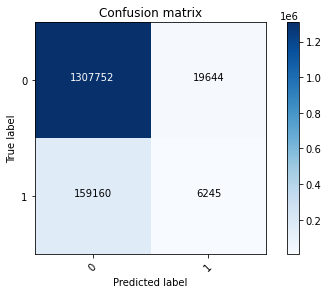

In [58]:
from sklearn.metrics import confusion_matrix
cm1718 = confusion_matrix(testy18, preds1718)
cm1817 =confusion_matrix(testy17, preds1817)
plot_confusion_matrix(cm1718,classes = range(2), normalize=False)
# plot_confusion_matrix(cm1718,classes = range(2), normalize=True)

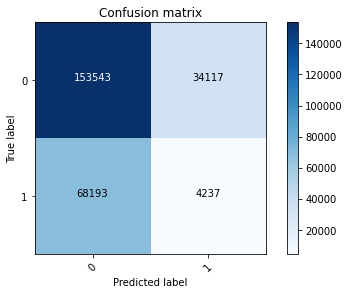

In [54]:
plot_confusion_matrix(cm1817,classes = range(2))

In [22]:
print("test acc for 17 attack classification", \
      score_nn_clf_with_scaler(clf_mul17,st_scaler_m17,testx_m17,testy_m17, False))
print("test acc for 18 attack classification",\
      score_nn_clf_with_scaler(clf_mul18,st_scaler_m18,testx_m18,testy_m18, False))

283/283 [==============================] - 1s 4ms/step - loss: 0.0080 - accuracy: 0.9991
test acc for 17 attack classification [0.007965688593685627, 0.9991300702095032]
647/647 [==============================] - 3s 4ms/step - loss: 0.0147 - accuracy: 0.9998
test acc for 18 attack classification [0.014719294384121895, 0.9997642040252686]


/home/saerom/.pyenv/versions/osrnn/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/saerom/.pyenv/versions/osrnn/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 150 missing from current font.
  font.set_text(s, 0, flags=flags)


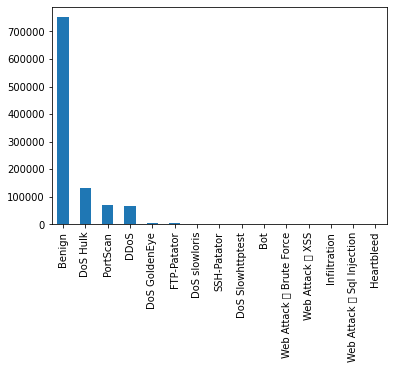

In [19]:
import matplotlib.pyplot as plt
ax17 = df_tr17['Label'].value_counts().plot(kind='bar')

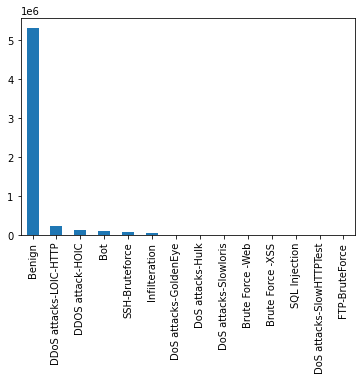

In [20]:
ax18 = df_tr18['Label'].value_counts().plot(kind='bar')

In [21]:
print(lab_name17)
print(lab_name18)

['Web Attack', 'DDoS', 'Bot', 'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'PortScan', 'FTP-Patator', 'SSH-Patator']
['Web Attack', 'DoS attacks-Hulk', 'DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'Bot', 'DDoS attacks-LOIC-HTTP', 'DDOS attack-HOIC', 'Infilteration', 'FTP-BruteForce', 'SSH-Bruteforce']


In [31]:
lab_728 = {0:0, 2:4, 3:3, 5:1, 6:2, 8:8, 9:9} #1: DDoS, 4: DoS Slowhttptest, 7: PortScan
lab_827 = {0:0, 1:5, 2:6, 3:3, 4:2, 8:8, 9:9} # 5: DDoS attacks-LOIC-HTTP, 6: DDOS attack-HOIC,  7: Infilteration

# test across datasets

## 18 -> 17

In [32]:
import seaborn as sns

In [35]:
import matplotlib.pyplot as plt
def test_nn_accross_dataset(train_df, clf, scaler, lab_map, lab_name1, lab_name2):
    for lab in lab_map:        
        ooc_col = lab
        true_col = lab_map[lab]
        print("OOC Label: ", lab_name1[ooc_col], "/ True Label: ", lab_name2[true_col])
        ooc_idx = (train_df['Label']==ooc_col)
        train_ooc = train_df.loc[ooc_idx]
        train_ooc = train_ooc.loc[:,train_ooc.columns!='Label']
        pred = apply_nn_clf_with_scaler(clf,scaler, train_ooc, False)        
        pred_ht,_ = np.histogram(pred, range=[0,10])        
        plt.bar(np.arange(10),pred_ht)
#         plt.hist(pred)
        plt.title("accuracy: "+str(float(sum(pred ==true_col)/len(pred))))
        plt.xticks(np.arange(10),lab_name2,rotation=90)
        plt.show()

apply 18 to 17
OOC Label:  Web Attack / True Label:  Web Attack
11/11 [==============================] - 0s 1ms/step


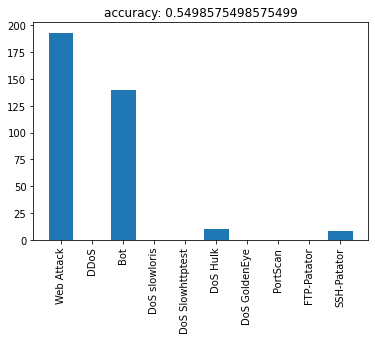

OOC Label:  DoS attacks-Hulk / True Label:  DoS Hulk
642/642 [==============================] - 1s 2ms/step


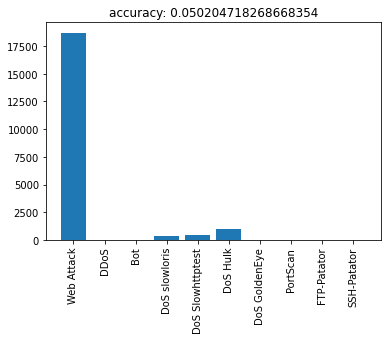

OOC Label:  DoS attacks-GoldenEye / True Label:  DoS GoldenEye
694/694 [==============================] - 1s 992us/step


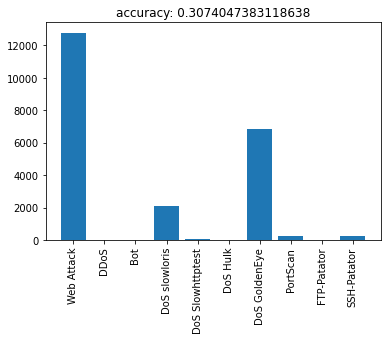

OOC Label:  DoS attacks-Slowloris / True Label:  DoS slowloris
191/191 [==============================] - 0s 1ms/step


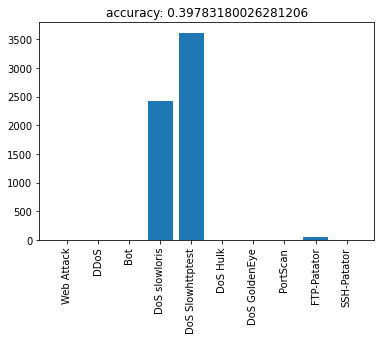

OOC Label:  Bot / True Label:  Bot
3570/3570 [==============================] - 9s 3ms/step


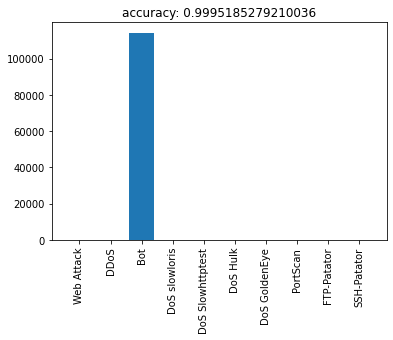

OOC Label:  FTP-BruteForce / True Label:  FTP-Patator
1/1 [==============================] - 0s 22ms/step


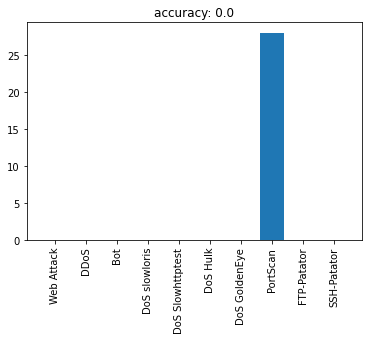

OOC Label:  SSH-Bruteforce / True Label:  SSH-Patator
2349/2349 [==============================] - 6s 3ms/step


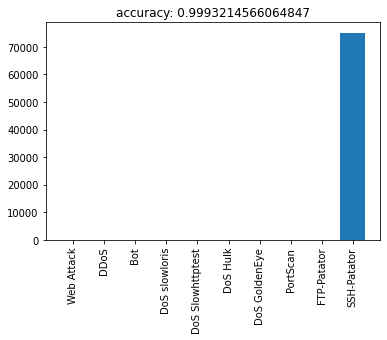

In [36]:
print("apply 18 to 17")
test_nn_accross_dataset(train_mul18, clf_mul17, st_scaler_m17, lab_827, lab_name18, lab_name17)

apply 17 to 18
OOC Label:  Web Attack / True Label:  Web Attack
55/55 [==============================] - 0s 3ms/step


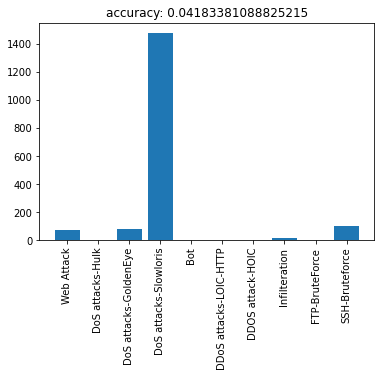

OOC Label:  Bot / True Label:  Bot
49/49 [==============================] - 0s 3ms/step


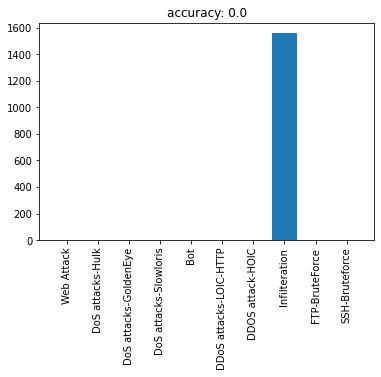

OOC Label:  DoS slowloris / True Label:  DoS attacks-Slowloris
94/94 [==============================] - 0s 2ms/step


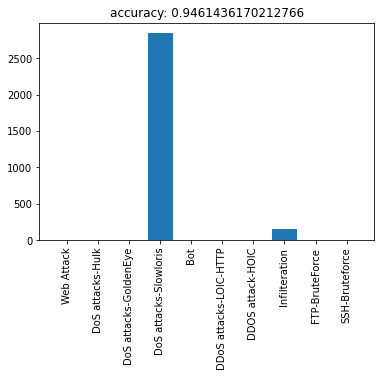

OOC Label:  DoS Hulk / True Label:  DoS attacks-Hulk
4082/4082 [==============================] - 7s 2ms/step


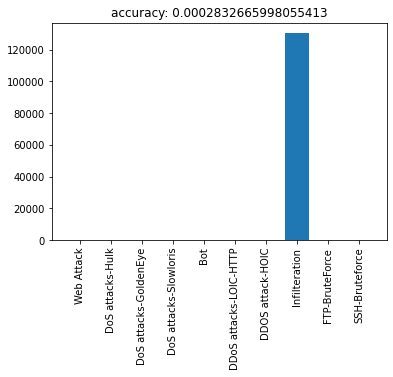

OOC Label:  DoS GoldenEye / True Label:  DoS attacks-GoldenEye
193/193 [==============================] - 0s 2ms/step


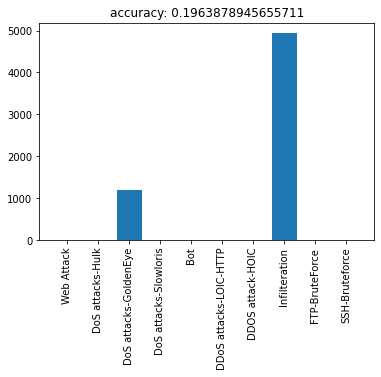

OOC Label:  FTP-Patator / True Label:  FTP-BruteForce
146/146 [==============================] - 0s 979us/step


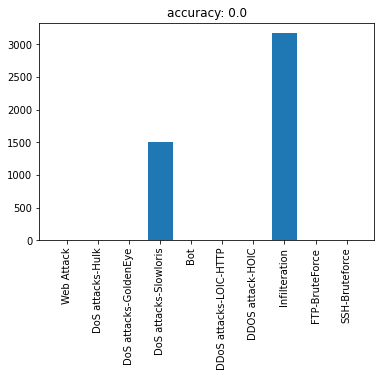

OOC Label:  SSH-Patator / True Label:  SSH-Bruteforce
82/82 [==============================] - 0s 932us/step


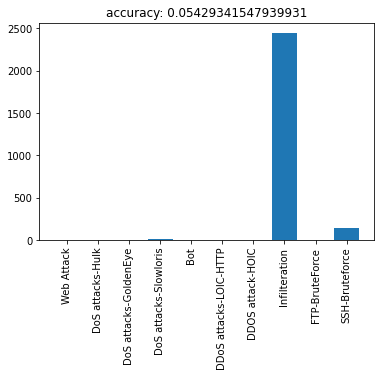

In [37]:
print("apply 17 to 18")
test_nn_accross_dataset(train_mul17, clf_mul18, st_scaler_m18, lab_728, lab_name17, lab_name18)

In [28]:
ooc_col = 9 # 
true_col = 9 # 
ooc_idx = (train_mul18['Label']==ooc_col)
train_ooc = train_mul18.loc[ooc_idx]
train_ooc = train_ooc.loc[:,train_ooc.columns!='Label']

In [29]:
import collections
ct = collections.Counter(train_ooc['Destination Port'].values)

In [30]:
train_ooc.shape

(75161, 67)

In [31]:
pred = apply_clf_with_scaler(lr_clfm17,st_scaler_m17, train_ooc)

In [32]:
sum(pred ==true_col)/len(pred)

0.9995476377376565

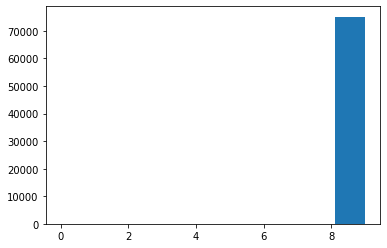

In [33]:
import matplotlib.pyplot as plt
plt.hist(pred)
plt.show()